In [27]:
import numpy as np
import random
from sklearn import linear_model
import matplotlib.pyplot as plt


- sk=0: using_sklearn=False, sk=1: using_sklearn=True
- modele_gen=lineaire, sin ou tanh
- nb_train: nombre de donnees d'entrainement
- nb_test: nombre de donnees de test
- bruit: amplitude du bruit appliqué aux données
- M: degré du polynome de la fonction de base (recherche d'hyperparametre lorsque M<0) 
- lambda: lambda utilisé par le modele de Ridge ( learning rate)

In [209]:
skl = 1
modele_gen = "sin"
nb_train = 80 
nb_test = 20
bruit = 0.3 # dispersion
m = 10
lamb = 0.001 # learning rate
w = [0.3, 4.1]  # Parametres du modele generatif

### Gestion Donnees

In [210]:
def generer_donnees():
    """
    Fonction qui genere des donnees de test et d'entrainement.

    modele_gen : 'lineaire', 'sin' ou 'tanh'
    nb_train : nb de donnees d'entrainement
    nb_test : nb de donnees de test
    bruit : amplitude du bruit (superieur ou egale a zero
    """
    np.random.seed(nb_train)
    x_train = np.random.rand(nb_train)
    x_test = np.random.rand(nb_test)
    if modele_gen == 'lineaire':
        t_train = w[0] + x_train * w[1] + np.random.randn(nb_train) * bruit
        t_test = w[0] + x_test * w[1] + np.random.randn(nb_test) * bruit
    elif modele_gen == 'sin':
        t_train = np.sin(x_train * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.sin(x_test * w[1] * 2) + np.random.randn(nb_test) * bruit
    else:
        t_train = np.tanh((x_train - 0.5) * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.tanh((x_test - 0.5) * w[1] * 2) + np.random.randn(nb_test) * bruit

    return x_train, t_train, x_test, t_test

In [211]:
def afficher_donnees_et_modele( x, t, scatter=True):
    """
    afficher des donnees

    x : vecteur de donnees
    t : vecteur de cibles
    scatter : variable determinant si on doit afficher une courbe ou des points
    """
    x_mod = np.arange(0, 1, 0.01)

    if modele_gen == 'lineaire':
        t_mod = w[0] + x_mod * w[1]
    elif modele_gen == 'sin':
        t_mod = np.sin(x_mod * w[1] * 2)
    else:
        t_mod = np.tanh((x_mod - 0.5) * w[1] * 2)

    if scatter is True:
        plt.scatter(x, t)
    else:
        idx = np.argsort(x)
        plt.plot(x[idx], t[idx], 'g')

    plt.plot(x_mod, t_mod, 'k')
    plt.ylim(ymin=-1.5, ymax=4.5)

In [212]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

### Regression

In [362]:
def fonction_base_polynomiale(x):
    """
    Fonction de base qui projette la donnee x vers un espace polynomial tel que mentionne au chapitre 3.
    Si x est un scalaire, alors phi_x sera un vecteur à M dimensions : (x^1,x^2,...,x^M)
    Si x est un vecteur de N scalaires, alors phi_x sera un tableau 2D de taille NxM

    NOTE : En mettant phi_x = x, on a une fonction de base lineaire qui fonctionne pour une regression lineaire
    """
    # AJOUTER CODE ICI
   
    if(type(x) == int):
        return np.array([x**i for i in range(1, m+1)]).reshape(m,1) # (x^1,x^2,...,x^M)
    else:
        x = x.reshape(-1,1)
        for i in range(2,m+1):
            x = np.hstack((x, (x[:, 0] ** i).reshape((len(x), 1))))
        return x# 2D de taille NxM

In [366]:
print("test fonction_base_polynomiale : avec m = 10")
print(" -> Si x est un scalaire : 2")
print(fonction_base_polynomiale(2))
print("shape :"+str(fonction_base_polynomiale(2).shape))
print(" -> Si x est un vecteur de n scalaires : [2, 3]")
print(fonction_base_polynomiale(np.array([2, 3])))
print("Shape :"+str(fonction_base_polynomiale(np.array([2, 3])).shape))

test fonction_base_polynomiale : avec m = 10
 -> Si x est un scalaire : 2
[[   2]
 [   4]
 [   8]
 [  16]
 [  32]
 [  64]
 [ 128]
 [ 256]
 [ 512]
 [1024]]
shape :(10, 1)
 -> Si x est un vecteur de n scalaires : [2, 3]
[[    2     4     8    16    32    64   128   256   512  1024]
 [    3     9    27    81   243   729  2187  6561 19683 59049]]
Shape :(2, 10)


In [220]:
def recherche_hyperparametre(X, t):
    """
    Validation croisee de type "k-fold" pour k=10 utilisee pour trouver 
    la meilleure valeur pour l'hyper-parametre M.

    Le resultat est mis dans la variable M

    X: vecteur de donnees
    t: vecteur de cibles
    """
    # AJOUTER CODE ICI
    
    
    m = 1

In [585]:
def entrainement(X, t, using_sklearn=False):
    """
    Entraîne la regression lineaire sur l'ensemble d'entraînement forme des
    entrees ``X`` (un tableau 2D Numpy, ou la n-ieme rangee correspond à 
    l'entree x_n) et des cibles ``t`` (un tableau 1D Numpy ou le
    n-ieme element correspond à la cible t_n). L'entraînement doit
    utiliser le poids de regularisation specifie par ``lamb``.

    Cette methode doit assigner le champs ``w`` au vecteur
    (tableau Numpy 1D) de taille D+1, tel que specifie à la section 3.1.4
    du livre de Bishop.

    Lorsque using_sklearn=True, vous devez utiliser la classe "Ridge" de 
    la librairie sklearn (voir http://scikit-learn.org/stable/modules/linear_model.html)

    Lorsque using_sklearn=False, vous devez implementer l'equation 3.28 du
    livre de Bishop. Il est suggere que le calcul de ``w`` n'utilise
    pas d'inversion de matrice, mais utilise plutôt une procedure
    de resolution de systeme d'equations lineaires (voir np.linalg.solve).

    Aussi, la variable membre M sert à projeter les variables X vers un 
    espace polynomiale de degre M(voir fonction fonction_base_polynomiale())

    NOTE IMPORTANTE : lorsque M <= 0, il faut trouver la bonne valeur de M

    """
    #AJOUTER CODE ICI
    if m <= 0:
        recherche_hyperparametre(X, t)

    phi_x = fonction_base_polynomiale(X)
    w = [0, 1]
    
    # using_sklearn=True
    if(using_sklearn==True):
        reg = linear_model.Ridge(alpha=.5)
        fit = reg.fit(phi_x, t)
        w = fit.coef_
        
    # using_sklearn=False
    if(using_sklearn==False):
        iterations = 10000
        w = np.random.rand(10)
        cost_history = []
        cost_history.append(costFunction(phi_x, t, w))

        for iteration in range(1, iterations):
            hypothesis = phi_x.dot(w)
            loss = hypothesis-t
            gradient = phi_x.T.dot(loss)/m
            w = w - lamb*gradient
            cost = np.sum((np.matmul(phi_x, w)-t)**2)/(2*m)
            cost_history.append(cost)
            #print(cost)
            if cost_history[iteration-1] - cost_history[iteration] < 0.00001:
                break
        plt.title('Fonction objectif J')
        plt.xlabel('iterations')
        plt.ylabel('Loss')
        plt.plot(cost_history)
        plt.show()
                

In [701]:
def prediction(x):
    """
    Retourne la prediction de la regression lineaire
    pour une entree, representee par un tableau 1D Numpy ``x``.

    Cette methode suppose que la methode ``entrainement()``
    a prealablement ete appelee. Elle doit utiliser le champs ``w``
    afin de calculer la prediction y(x,w) (equation 3.1 et 3.3).
    """
    # AJOUTER CODE ICI
    """ il faut la calculer """
    w0 = 0.1
    y = w0 + x.reshape(-1,1) @ W.reshape(1,-1)
    
    return y

In [702]:
def erreur(t, prediction):
    """
    Retourne l'erreur de la difference au carre entre
    la cible ``t`` et la prediction ``prediction``.
    """
    # AJOUTER CODE ICI
    """ pas sure """
    return (t-prediction)**2

In [703]:
def warning(erreur_test, erreur_apprentissage, bruit):
    """
    Fonction qui affiche un WARNING à l'ecran lorsque les erreurs obtenues en fonction du bruit
    indique une possibilite de sur- ou de sous-apprentissage

    erreur_test: erreur obtenue sur l'ensemble de test
    erreur_apprentissage: erreur obtenue sur l'ensemble d'apprentissage
    bruit: magnitude du bruit
    """
    # AJOUTER CODE ICI
    
    

### Run

In [704]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

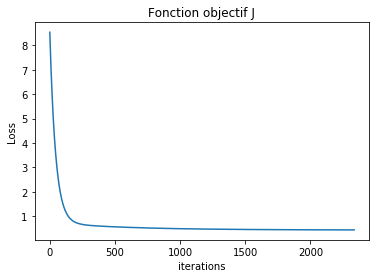

In [705]:
# Entrainement du modele de regression
entrainement(x_train, t_train, using_sklearn=False)

In [706]:
# Predictions sur les ensembles d'entrainement et de test
predictions_train = prediction(x_train)
predictions_test = prediction(x_test)
#predictions_train = np.array([prediction(x) for x in x_train])
#predictions_test = np.array([prediction(x) for x in x_test])

In [707]:
# Calcul des erreurs
erreurs_entrainement = np.array([erreur(t_n, p_n)
                                 for t_n, p_n in zip(t_train, predictions_train)])
erreurs_test = np.array([erreur(t_n, p_n)
                         for t_n, p_n in zip(t_test, predictions_test)])

print("Erreur d'entraînement :", "%.2f" % erreurs_entrainement.mean())
print("Erreur de test :", "%.2f" % erreurs_test.mean())
print("")

warning(erreurs_test.mean(), erreurs_entrainement.mean(), bruit)

Erreur d'entraînement : 0.18
Erreur de test : 0.14



In [708]:
def meanAbsoluteError(y,x):
        temp = np.sum(np.abs(y.reshape(-1,1) - x))
        return (1/len(y)) * temp

print("Erreur absolue moyenne d'entraînement :", "%.2f" % meanAbsoluteError(t_train, predictions_train))
print("Erreur absolue moyenne de test :", "%.2f" % meanAbsoluteError(t_test,predictions_test))

Erreur absolue moyenne d'entraînement : 3.45
Erreur absolue moyenne de test : 2.91


In [709]:
def meanSquareError(y,x):
        temp = np.sum(np.power(y.reshape(-1,1) - x,2))
        return np.sqrt((1/len(y)) * temp)
    
print("Erreur quadratique moyenne d'entraînement :", "%.2f" % meanSquareError(t_train, predictions_train))
print("Erreur quadratique moyenne de test :", "%.2f" % meanSquareError(t_test,predictions_test))

Erreur quadratique moyenne d'entraînement : 1.33
Erreur quadratique moyenne de test : 1.17


In [712]:
def r2(y,x):
    temp1 = np.sum(np.power(y.reshape(-1,1) - x,2))
    temp2 = np.sum(np.power(y - np.mean(y),2))
    return 1 - (temp1/temp2)
""" neg parce que w0 est predeterminée"""
print("R² d'entraînement :", "%.2f" % r2(t_train, predictions_train))
print("R² de test :", "%.2f" % r2(t_test,predictions_test))

R² d'entraînement : -15.32
R² de test : -18.44


ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 1, 10)

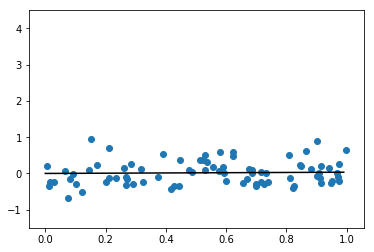

In [640]:
# Affichage
afficher_donnees_et_modele(x_train, t_train, True)
predictions_range = np.array([prediction(x) for x in np.arange(0, 1, 0.01)])
afficher_donnees_et_modele(np.arange(0, 1, 0.01), predictions_range, False)

if m >= 0:
    plt.suptitle('Resultat SANS recherche d\'hyperparametres')
else:
    plt.suptitle('Resultat AVEC recherche d\'hyperparametres')
plt.show()